In [1]:
import numpy as np # linear algebra
import pandas as pd 
import os
import gc
import sklearn.model_selection
import lightgbm

In [2]:
# csv_path="/export/storage_cpoliqui/data/raw/wages2008.tsv"

# data_2008=pd.read_csv(csv_path, sep='\t', header=0)
# data_2008.head()

In [3]:
#data_2008.info()

In [4]:
#change data_frame to matrix then slice it and change back to csv
#read CSVs in turn and do the processing

In [5]:
header_raw=["Firm_Identifier","Establishment_Identifier","Year","emp_present_12_31","Worker_Identifier",\
      "Avg_Month_Wage_In_miniWage","contract_salary_rea","salary_type","Weekly_hrs","Occupation_code","reason_leave",
      "How_worker_entered","date_enter","date_left","employment_type","tenure_in_month","female","Education_level",
      "nationality","Race","Age","municipality","Corp_Form","Industry_cnae"]


In [6]:
#data_2008.head(15)

In [7]:

csv_path="whole_data_2008.csv"
data_2=pd.read_csv(csv_path, header=0)
data_2.drop(columns="Unnamed: 0",inplace=True)


In [8]:
#process raw data
def transform_sal (sal_type,Weekly_hrs,contract_salary_rea):
    map_a={1:4.333,2:2.1667,3:1,4:0.2,5:1/Weekly_hrs}
    return contract_salary_rea/(Weekly_hrs*map_a[sal_type])
v_transform_sal=np.vectorize(transform_sal)

def process_data(data_1):
    data_1.drop(columns="date_left",inplace=True)
    data_1.drop(columns="date_enter",inplace=True)
    mode_race=data_1["Race"].mode()
    data_1["Race"].fillna(mode_race,inplace=True)
    data_1.dropna(inplace=True)

    data_1["contract_salary_rea"]=data_1["contract_salary_rea"]/100
    data_1=data_1.query('salary_type<=5')
    data_1=data_1.loc[(data_1["Firm_Identifier"]>=10)&(data_1["Race"]!=9)]
    data_1=data_1.loc[(data_1["contract_salary_rea"]>0)&(data_1["Avg_Month_Wage_In_miniWage"]>0)]   
    data_1["hr_salary"]=v_transform_sal(data_1["salary_type"].values,data_1["Weekly_hrs"].values,data_1["contract_salary_rea"].values)
    data_1.loc[:,"hr_salary_log"]=np.log(data_1["hr_salary"])
    
    #get rid of a small portion of entries where log(w)<0
    data_1=data_1.loc[(data_1["hr_salary_log"]>=0)]
    
    data_1=data_1.reset_index(drop=True)
    
    return data_1

    

data_2=process_data(data_2) # whole data 





In [9]:
#set aside multi market firm from single market firm
def Single_Multiple(data_1):
    a=data_1.groupby(["Firm_Identifier"])["municipality"].nunique()
    single_market_id=a.loc[a==1]
    multi_market_id=a.loc[a!=1]
    multi_market_id=pd.Series(multi_market_id.index)
    single_market_id=pd.Series(single_market_id.index)

    single_market_firm=data_1.loc[data_1['Firm_Identifier'].isin(single_market_id)]
    multi_market_firm=data_1.loc[data_1['Firm_Identifier'].isin(multi_market_id)]
    return single_market_firm, multi_market_firm


single_market_firm_whole, multi_market_firm_whole=Single_Multiple(data_2) # whole data 

In [10]:
#disregard this block, not used further

def get_train_test(data_1):
    train_, test_ = sklearn.model_selection.train_test_split(
        data_1, train_size=0.1, test_size=0.9, random_state=42)
    print('Train:', train_.shape, 'Test:', test_.shape)    
    train_.reset_index(drop=True,inplace=True)
    test_.reset_index(drop=True,inplace=True)
    return train_, test_ 

single_train,single_test  =get_train_test(single_market_firm_whole)


Train: (3016748, 25) Test: (27150734, 25)


In [11]:
def get_validation(data_1):
    train_, test_ = sklearn.model_selection.train_test_split(
        data_1, train_size=0.1, test_size=0.9, random_state=24)
    print('Train:', train_.shape, 'Test:', test_.shape)    
    train_.reset_index(drop=True,inplace=True)
    test_.reset_index(drop=True,inplace=True)
    return train_
single_valid=get_validation(single_market_firm_whole)

Train: (3016748, 25) Test: (27150734, 25)


In [12]:
def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    result=t.drop(columns=["Year",
                    "Worker_Identifier","Avg_Month_Wage_In_miniWage",
                    "contract_salary_rea","hr_salary_log","hr_salary","emp_present_12_31"])
    result.reset_index(drop=True,inplace=True)
    return result

In [13]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

In [14]:
#xgboost model set up

import lightgbm as lgb

cat_cols=['Occupation_code', 
       'employment_type' ,
       'Industry_cnae']

train_data=lgb.Dataset(design_matrix(single_train),label=single_train["hr_salary_log"])
validation_data = train_data.create_valid(design_matrix(single_valid))
header=design_matrix(single_train).columns

header

Index(['Firm_Identifier', 'Establishment_Identifier', 'salary_type',
       'Weekly_hrs', 'Occupation_code', 'reason_leave', 'How_worker_entered',
       'employment_type', 'tenure_in_month', 'female', 'Education_level',
       'nationality', 'Race', 'Age', 'municipality', 'municipality_micro',
       'Corp_Form', 'Industry_cnae'],
      dtype='object')

In [30]:
core_params = {
    'boosting_type': 'gbdt', # rf, dart, goss
    'objective': 'regression', # regression, multiclass, binary
    'learning_rate': 0.05,
    'num_leaves': 150,
    'nthread': 8,
    'metric': 'rmse' # binary_logloss, mse, mae
}

advanced_params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    
    'learning_rate': 0.05,
    'num_leaves': 250, # more increases accuracy, but may lead to overfitting.
    
    'max_depth': 20, # shallower trees reduce overfitting.
    'min_split_gain': 1, # minimal loss gain to perform a split.
    'min_child_samples': 61, # specifies the minimum samples per leaf node.
    'min_child_weight': 5, # minimal sum hessian in one leaf.
    
    #'lambda_l1': 0, # L1 regularization.
    'lambda_l2': 0.5, # L2 regularization.
    
    # LightGBM can subsample the data for training (improves speed):
    'feature_fraction': 0.5, # randomly select a fraction of the features.
    'bagging_fraction': 0.5, # randomly bag or subsample training data.
    'bagging_freq': 0, # perform bagging every Kth iteration, disabled if 0.
    
    
    #'subsample_for_bin': 200, # sample size to determine histogram bins.
    'max_bin': 40000, # maximum number of bins to bucket feature values in.
    
    'nthread': 20, # best set to number of actual cores.
}

num_round=250
evals_result = {}
gbm = lgb.train(advanced_params, 
                train_data,
                num_round, valid_sets=[validation_data])
                #init_model=init_gbm, # enables continuous training.
                # number of boosting rounds.
                
                #valid_sets=validation_set,
               # evals_result=evals_result, # stores validation results.
                 # print evaluations during training.verbose_eval=False
#Model_single :Trained on the Single Market Firm employee in a sample.

#prediction on multi-market firm workers by model_single_sample

multi_pred = gbm.predict(design_matrix(multi_market_firm_whole))

single_pred=gbm.predict(design_matrix(single_test))
print(rmse(single_pred.reshape(1,-1)[0]-single_test["hr_salary_log"]))

[1]	valid_0's rmse: 1.29935
[2]	valid_0's rmse: 1.29954
[3]	valid_0's rmse: 1.29985
[4]	valid_0's rmse: 1.30042
[5]	valid_0's rmse: 1.30123
[6]	valid_0's rmse: 1.30211
[7]	valid_0's rmse: 1.303
[8]	valid_0's rmse: 1.30404
[9]	valid_0's rmse: 1.30528
[10]	valid_0's rmse: 1.30667
[11]	valid_0's rmse: 1.30779
[12]	valid_0's rmse: 1.30835
[13]	valid_0's rmse: 1.3097
[14]	valid_0's rmse: 1.31107
[15]	valid_0's rmse: 1.31258
[16]	valid_0's rmse: 1.31377
[17]	valid_0's rmse: 1.31544
[18]	valid_0's rmse: 1.31682
[19]	valid_0's rmse: 1.31732
[20]	valid_0's rmse: 1.31875
[21]	valid_0's rmse: 1.32036
[22]	valid_0's rmse: 1.32212
[23]	valid_0's rmse: 1.32342
[24]	valid_0's rmse: 1.32446
[25]	valid_0's rmse: 1.32602
[26]	valid_0's rmse: 1.32751
[27]	valid_0's rmse: 1.32908
[28]	valid_0's rmse: 1.33039
[29]	valid_0's rmse: 1.33198
[30]	valid_0's rmse: 1.33356
[31]	valid_0's rmse: 1.33475
[32]	valid_0's rmse: 1.33607
[33]	valid_0's rmse: 1.3371
[34]	valid_0's rmse: 1.33769
[35]	valid_0's rmse: 1.3391

In [16]:
#results distribution
check=multi_pred-multi_market_firm_whole["hr_salary_log"]
check.describe()

count    1.460951e+07
mean    -7.681891e-02
std      5.930168e-01
min     -9.391696e+00
25%     -2.118466e-01
50%      2.027853e-03
75%      1.583962e-01
max      6.684819e+00
Name: hr_salary_log, dtype: float64

<Figure size 1080x432 with 0 Axes>

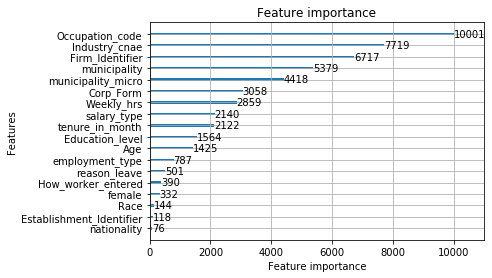

In [26]:
#Feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
lgb.plot_importance(gbm)
plt.savefig("feature_importance", dpi=400)

In [28]:
#summary stats
# multi market employee
pd.DataFrame(multi_pred).describe()

,0
count,1.460951e+07
mean,1.513167e+00
std,6.466572e-01
min,5.197923e-01
25%,1.075337e+00
50%,1.320365e+00
75%,1.721402e+00
max,8.472494e+00


In [19]:
pd.DataFrame(multi_market_firm_whole["hr_salary_log"]).describe()

,hr_salary_log
count,1.460951e+07
mean,1.594294e+00
std,8.939977e-01
min,0.000000e+00
25%,1.001454e+00
50%,1.320433e+00
75%,1.907823e+00
max,1.099514e+01


In [20]:
pd.DataFrame(single_pred).describe()

,0
count,2.715073e+07
mean,1.298567e+00
std,5.091318e-01
min,3.974620e-01
25%,9.886609e-01
50%,1.174832e+00
75%,1.435330e+00
max,1.038597e+01


In [21]:
pd.DataFrame(single_test["hr_salary_log"]).describe()

,hr_salary_log
count,2.715073e+07
mean,1.299194e+00
std,6.628604e-01
min,0.000000e+00
25%,9.022829e-01
50%,1.146480e+00
75%,1.457439e+00
max,1.520180e+01


In [22]:
# regression 
# X:  Expected multi-market firm wage based on single-market-firm model
# Y:  Multi-market firm real wage

from sklearn.linear_model import LinearRegression
model = LinearRegression()

multi_pred=multi_pred.reshape(-1, 1)
single_pred=single_pred.reshape(-1, 1)

reg_1=model.fit(multi_pred, multi_market_firm_whole["hr_salary_log"]) #multi market data on single market


In [23]:
# coefficients
k_multi=reg_1.coef_
intercept_multi=reg_1.intercept_
print(reg_1.coef_)
print(reg_1.intercept_)

[1.04705213]
0.00992926142198125


In [24]:
#single market data regression Coeffecients (for comparision)
reg_2=model.fit(single_pred , single_test["hr_salary_log"]) 
k_single=reg_2.coef_
intercept_single=reg_2.intercept_

print(reg_2.coef_)
print(reg_2.intercept_)

[1.07130841]
-0.09197221334286287


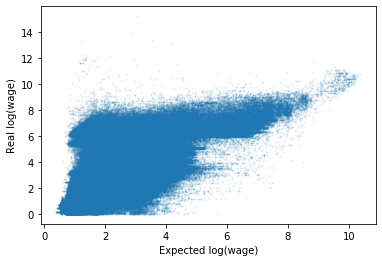

In [25]:
#plot
#single market, Real VS Expected wage, whole dataset
import matplotlib.pyplot as plt
plt.scatter(single_pred, single_test["hr_salary_log"],s=1,alpha=0.1) 

plt.xlabel('Expected log(wage)')
plt.ylabel('Real log(wage)')
plt.show()

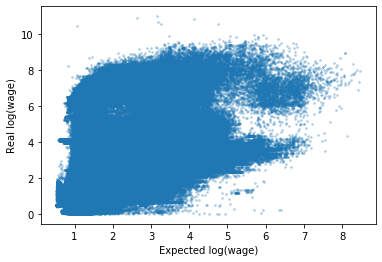

In [26]:
# multi market, Real VS (single-market firm) Expected wage, whole dataset
plt.scatter(multi_pred , multi_market_firm_whole["hr_salary_log"],s=3,alpha=0.25) 
plt.xlabel('Expected log(wage)')
plt.ylabel('Real log(wage)')
plt.show()

In [27]:
#
plt.figure(figsize=(9, 6))
#x_1 = np.linspace(0, 10, 1000)
#x_2= np.linspace(0, 10, 1000)
plt.scatter(multi_pred, multi_market_firm_whole["hr_salary_log"],s=2,alpha=0.15,label='multi-market employee')
#plt.plot(x_2, k_single*x + intercept_single, linestyle='solid')

plt.scatter(single_pred, single_test["hr_salary_log"],s=2,alpha=0.2,label='single-market employee')
#plt.plot(x_1, k_multi*x + intercept_multi, linestyle='solid')
plt.legend()
plt.grid(True)
plt.xlabel('Expected log(wage) under single-market model')
plt.ylabel('Real log(wage)')
fig_id="whole"
fig_path = os.path.join(fig_id + "." + "png")
plt.savefig(fig_path, format="png", dpi=400)
plt.show()


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fafbf917830> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fafbf6d4c20> (for post_execute):


KeyboardInterrupt: 

In [ ]:
import binscatter

fig, axes = plt.subplots(2)
axes[0].binscatter(single_pred ,single_test["hr_salary_log"])
axes[0].set_xlabel('Expected log(wage) under single-market model')
axes[0].set_ylabel('Real log(wage)')

axes[1].binscatter(multi_pred ,multi_market_firm_whole["hr_salary_log"])
axes[1].set_xlabel('Expected log(wage) under single-market model')
axes[1].set_ylabel('Real log(wage)')
plt.show()

In [ ]:
fig, axes = plt.subplots()
axes.binscatter(single_pred ,single_test["hr_salary_log"])
axes.set_xlabel('Expected log(wage) under single-market model')
axes.set_ylabel('Real log(wage)')

axes.binscatter(multi_pred,multi_market_firm_whole["hr_salary_log"])
axes.set_xlabel('Expected log(wage) under single-market model')
axes.set_ylabel('Real log(wage)')
plt.show()